In [1]:
import requests
import base64
import json
import os
from IPython.display import Image

In [35]:
api_key = '<your key here>'
base_url = 'http:<endpoint here>'

# API Examples

The api is a REST API that exposes HTTP endpoints. The following demonstrates using Python's request library, but you can use any technique that is capable of making HTTP requests to access the API. 


## Authenticating & Headers

Your api key should be passed as a Bearer token in the `authorization` header.

The value of the `Content-Type` header should be `application/json`.

In [7]:
endpoint = f"{base_url}/chat/completions"

headers = {
    'accept': 'application/json',
    'authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
}

## Minimal Chat Example

The simplest possible chat with just a model and a user prompt.

In [13]:
data = {
  "model": "claude_3_haiku",
  "messages": [
    {
      "role": "user",
      "content": "Hello"
    }
  ]
}

In [14]:
resp = requests.post(endpoint, json=data, headers=headers)
if resp.status_code >= 300:
    print("error", resp.status_code)

response_object = resp.json()
response_object

{'object': 'chat.completion',
 'created': 1748553268,
 'model': 'claude_3_haiku',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': 'Hi there! How are you doing today? Is there anything I can help you with?'},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 8, 'completion_tokens': 21, 'total_tokens': 29}}

## Using a system prompt

The `messages` array can contain mutlple content items of various types. Including a system prompt influences how the model behaves.

In [15]:
data = {
  "model": "claude_3_5_sonnet",
  "messages": [
    {
      "role": "system",
      "content": "You are a pirate and only speak in pirate"
    },
    {
      "role": "user",
      "content": "Hello"
    }
  ]
}

In [16]:
resp = requests.post(endpoint, json=data, headers=headers)
if resp.status_code >= 300:
    print("error", resp.status_code)

response_object = resp.json()
response_object['choices'][0]['message']['content']

"Yarr, ahoy there matey! *adjusts eye patch* What brings ye to these waters today? I be ready to help ye with whatever ye need, so long as it don't involve mutiny or walkin' the plank! Speak up, me hearty!"

## Including image data with prompt

Images must be encoded as a data URI like`data:image/jpg;base64,<base64 data>`

Include the image as another content item with

```
{
  "type": "image_url",
  "image_url": { 
    "url":encoded  # your base64 encoded string
  },
  "detail": "auto"
}
```

Below we have a request object with three items:
1. System prompt
2. User prompt
3. Image content

The example also demonstrates crafting the prompt to encourage the model to respond with valid JSON data.

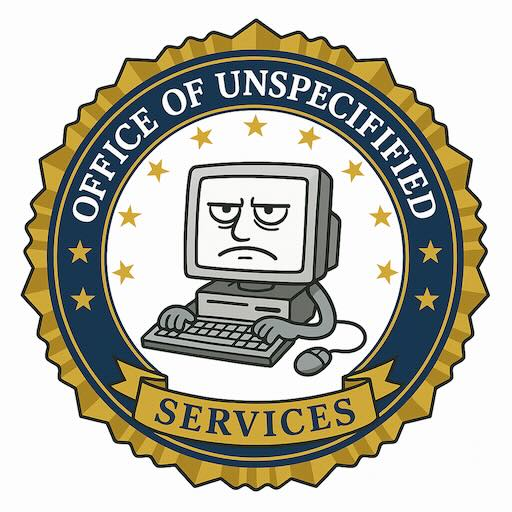

In [20]:
seal_image_path = "images/ous_white.jpg" 
stapler_image_path = "images/red_stapler.jpg"
Image(filename=seal_image_path)

In [188]:
def make_prompt(image_path, description):
    image = Image(filename=image_path)
    image_bytes = image.data
    # encode image bytes as base64
    # and create a data url
    s = base64.b64encode(image_bytes).decode('utf-8')
    encoded = 'data:image/png;base64,'+s
    return {
        "model": "gemini-2.0-flash",
        "messages": [
            {
                "role": "system",
                "content": """
                    I want to directly parse your response as json. Do not include any other text other than the plain json. 
                    Do not not include the word json, do not include new line characters. Only the exact json text.
                    """
            },
            {
                "role": "user",
                "content": [
                {
                  "type": "text",
                  "text": f"""I have the following description of this image:
                  {description} 
                  I would like to know if this description as genally correct. The description does not need to be 
                  specfic or detailed. The general category is still considered correct if it matches
                  the image. Format your answer as a json object with two pieces of information, a boolean indicating
                  whether the teh description matches, and a description, which is your identification of the image:
                  {{"is_correct": boolean indicating if the description is generally correct, "description":your description of the image.}}.
                  """
                },
                {
                  "type": "image_url",
                  "image_url": { 
                    "url":encoded
                  },
                  "detail": "auto"
                }
                ]
            }
        ]
    }


In [190]:
prompt = make_prompt(seal_image_path, "a red stapler")

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_content = response_object['choices'][0]['message']['content']
json.loads(response_content)

{'is_correct': False,
 'description': "A cartoon image of a desktop computer wearing an angry face, integrated into an official looking seal with the text 'OFFICE OF UNSPECIFIED SERVICES'"}

## Including documents

Similar to images, documents are included as another content item with base 64 data. Note that documents are not formated as data urls, but are passed as bytes encoded as base 64 strings to the `file_data`.


In [191]:
def make_document_prompt(model, document_path, prompt):
    with open(document_path, 'rb') as f:
        pdf_bytes = f.read()
        pdf_base_64 = base64.b64encode(pdf_bytes).decode('utf-8') 

    return {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                {
                  "type": "text",
                  "text": prompt
                },
                {
                  "type": "file",
                  "file_name": "Test",
                  "file": { 
                    "file_data":pdf_base_64
                  }
                }
                ]
            }
        ]
    }

In [192]:
prompt = make_document_prompt(
    "gemini-2.0-flash",
    "documents/AWorldofLovesample.pdf", 
    "Please summarize this document."
)

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_object['choices'][0]['message']['content']

'This passage describes a landscape in Ireland, specifically the grounds surrounding a mansion called Montefort. The mansion appears to be in a state of decline, with overgrown grounds and a neglected facade. The passage introduces a young woman named Jane, dressed in an Edwardian muslin dress, who is beautiful and appears to be pondering over a letter. She gazes back at the mansion, focusing on two windows on the top storey. The scene then shifts to inside one of the rooms, where the light is red and filled with clutter and a fourposter bed.\n'

## Model Differences

Different models have different capabilities. The document`AWorldofLovesample.pdf`, which we passed to the model above, is a scanned PDF that only contains an image of the text — it doesn't contain any text content. Gemini is capable of performing OCR on the image and extracting text from it.

On the other hand, Claude does not do this (at the moment) and responds that it sees a blank doucment. To effectively use this API, it is important to understand the differences between the underlying models.

In [193]:
prompt = make_document_prompt(
    "claude_3_haiku",
    "documents/AWorldofLovesample.pdf", 
    "Please summarize this document."
)

resp = requests.post(endpoint, json=prompt, headers=headers)
response_object = resp.json()
response_object['choices'][0]['message']['content']

'I apologize, but I cannot summarize the document because the document content is empty. The document appears to be a PDF file named "Untitled.pdf", but no text or content is present in the document to analyze or summarize.'

# Embeddings

In [194]:
endpoint = f"{base_url}/embeddings"

headers = {
    'accept': 'application/json',
    'authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
}

In [195]:
request = {
  "model": "cohere_english_v3",
  "encodingFormat": "float",
  "input": [
      "Sweet is the breath of morn, her rising sweet, With charm of earliest birds",
      "With Midnight to the North of Her — And Midnight to the South of Her — And Maelstrom — in the Sky"
  ],
  "input_type": "search_document"
}


In [196]:
resp = requests.post(endpoint, json=request, headers=headers)
result = resp.json()

In [197]:
result['data'][0]['embedding'][0:10]

[-0.0036468506,
 -0.023422241,
 -0.038757324,
 -0.038635254,
 -0.008544922,
 -0.0076293945,
 0.004508972,
 0.022476196,
 0.0019721985,
 0.017059326]

## Using embeddings for simple clustering

Embeddings are frequently used for [Retrieval Augmented Generation (RAG)](https://en.wikipedia.org/wiki/Retrieval-augmented_generation)) applications. But the semantic data captured in the embedding vectors has uses beyond RAG. 

This is a simple example that creates embeddings for 96 headlines. (We choose 96 here for simplcity since Cohere allows us to embed up to 96 documents in one call). These embeddings are put through a dimension reduction algorithm and then plotted showing the clustering based on semantic information.

In [132]:
## If you need to install these:
# !pip -q install datasets

import os, random, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap.umap_ as umap
from datasets import load_dataset
from sklearn.metrics import silhouette_score

## Create a small corpus of new headlines

This uses a dataset provided by [Hugging Face datatest](https://huggingface.co/datasets/sh0416/ag_news) and selects a random sample with equal representation from three catagories.

In [146]:
dataset = load_dataset('ag_news', split='train')  # 120k rows
label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

target_labels = [0, 1, 3]  # World, Sports, Sci/Tech
sample_size = 32 

rows = []
for lbl in target_labels:
    subset = [r for r in dataset if r['label'] == lbl]
    rows.extend(random.sample(subset, sample_size))

texts = [r['text'] for r in rows]
labels = [label_names[r['label']] for r in rows]

In [198]:
print(f"Loaded {len(texts)} headlines: {[f'{l}={labels.count(l)}' for l in set(labels)]}\n")
print("Example text:", texts[0])

Loaded 96 headlines: ['Sports=32', 'World=32', 'Sci/Tech=32']

Example text: India #39;s Congress win in state helps national clout India #39;s ruling Congress party, flush with an election win in the state that is the heart of finance and film, will now be better armed to deal with demanding communist allies, newspapers and analysts said on Sunday.


## Use the API to get embeddings for each headline

Because we limited the number of headlines to 96, we can do this in one request to the API. If we had a larger set, we would need to split them into groups of 96. If the documents were larger than headlines, we would also need to split documents into a size smaller than the Cohere token limit.

In [139]:
request = {
  "model": "cohere_english_v3",
  "encodingFormat": "float",
  "input": texts,
  "input_type": "clustering"
}

resp = requests.post(endpoint, json=request, headers=headers)
result = resp.json()

In [141]:
raw_embeddings = [data['embedding'] for data in result['data']]
embeddings = np.array(raw_embeddings)
embeddings.shape

(96, 1024)

## Reduce dimensions

Cohere embeddings have 1024 dimensions. This allows the embedding to capture semantic meaning on many different layers, but also makes it challenging to visualize. [UMAP learn](https://umap-learn.readthedocs.io/en/latest/) uses a non-linear dimensionality-reduction algorithm that tries to keep points that are close together in the high-dimensional space close together in the low-dimensional map. This is useful for visualizations. 

From the plot below, we can see that we were able to effectively cluster these headlines by category just from the text of the headlines.

In [149]:
reducer = umap.UMAP(random_state=42, n_jobs=1, min_dist=0.2)
emb_2d = reducer.fit_transform(embeddings)

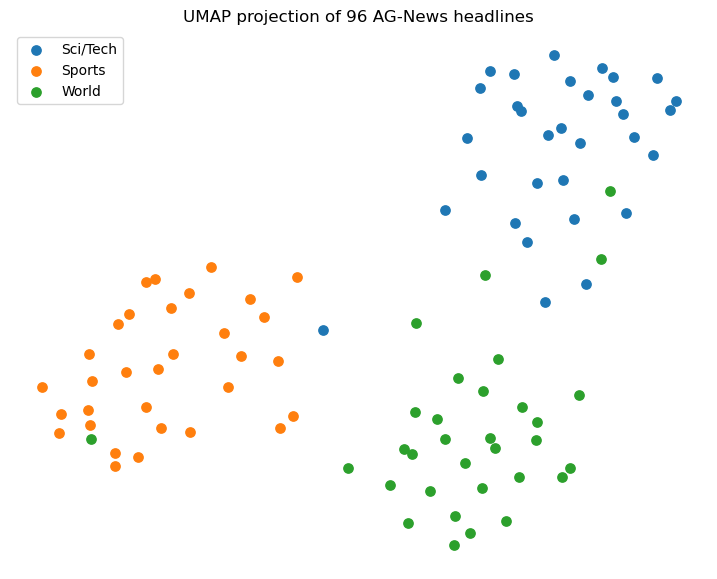

In [150]:
plt.figure(figsize=(9,7))
unique_labels = sorted(set(labels))
colors = {lbl: idx for idx, lbl in enumerate(unique_labels)}

for lbl in unique_labels:
    idxs = [i for i, l in enumerate(labels) if l == lbl]
    plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=lbl, s=45)

plt.title('UMAP projection of 96 AG‑News headlines')
plt.legend()
plt.axis('off')
plt.show()